# Data Processing for full cohort








## Split Predictors and Readmission Targert

In [ ]:
# Upload files to colab environment
from google.colab import files
uploaded = files.upload()

Saving full_cohort.csv to full_cohort.csv


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns


# Load dataset

file_path = 'full_cohort.csv'
df = pd.read_csv(file_path, index_col=0)

# Separate features and target
# Assuming 'has_readmission' is the target column
X = df.drop(columns=['has_readmission', 'subject_id', 'hadm_id'], errors='ignore')
y = df['has_readmission']



In [ ]:
X.head()

,age,gender,weight,height,n_stays,sum_los,rec_temperature_max_F,sbp_max,heart_rate_avg,respiratory_rate_avg,...,rbc_max,lactate_level_max,alb_level_min,trt_max,glucose_extreme_count,sodium_extreme_count,has_hypertension,has_diabetes,has_af,charlson_comorbidity_index
subject_id,,,,,,,,,,,,,,,,,,,,,
10109085,67,M,91.200000,180.0,1,4.921944,99.3,170.0,89.293333,20.607843,...,0.0,1.0,NaN,NaN,0,3,0,0,1,0
10145374,74,M,84.500000,NaN,2,4.908090,99.5,NaN,60.242424,15.991803,...,NaN,NaN,3.6,0.24,6,15,1,1,0,0
10176458,71,F,55.416667,157.0,2,8.989248,100.0,183.0,75.514925,19.270769,...,NaN,6.3,2.6,0.02,4,4,1,0,0,0
10203995,61,F,73.550000,NaN,2,2.397836,100.5,NaN,77.121212,18.711864,...,NaN,1.2,3.1,3.51,2,17,0,1,0,0
10248673,69,M,69.950000,NaN,1,3.613241,99.3,NaN,77.955556,19.250000,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [ ]:
y.head()

,has_readmission
subject_id,
10109085,1
10145374,1
10176458,1
10203995,1
10248673,1


In [ ]:
feature_tracker = {}
feature_tracker['initial'] = X.columns.tolist()

## Evaluation Function (Check effects after processing)

In [ ]:
# Define a function to evaluate model performance
def evaluate_model(X, y, step_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f"Model accuracy after {step_name}: {score:.4f}")

# Initial data overview
print("Initial data overview:")
print(X.describe())
print("Missing values per column:")
print(X.isnull().sum())

Initial data overview:
               age       weight       height      n_stays      sum_los  \
count  2016.000000  2008.000000  1126.000000  2016.000000  2016.000000   
mean     69.221726    80.746028   168.825222     1.138393     5.454389   
std      14.947350    20.651705    11.203901     0.422910     7.184710   
min      19.000000    35.000000   109.000000     1.000000     0.090417   
25%      60.000000    66.400000   160.000000     1.000000     1.397772   
50%      71.000000    78.212500   168.000000     1.000000     2.808617   
75%      81.000000    92.412500   178.000000     1.000000     6.485868   
max      91.000000   195.483333   244.000000     5.000000    66.584236   

       rec_temperature_max_F      sbp_max  heart_rate_avg  \
count            1992.000000  1032.000000     1993.000000   
mean               99.991516   180.723837       79.471395   
std                 1.590966    33.556564       12.270889   
min                94.000000    88.000000       42.750000   
25%  

## Outliers Handling
* Statistical Outliers Removing
* Non-Physiologic Outliers Removing



In [ ]:
# Step 1: Outliers Handling
# Define thresholds for non-physiologic outliers
physiological_bounds = {
'heart_rate_avg': (30, 220),  # Heart rate (bpm)
    'respiratory_rate_avg': (5, 60),  # Respiratory rate (breaths per minute)
    'sbp_max': (50, 300),  # Systolic blood pressure (mmHg)
    'weight': (30, 200),  # Weight (kg) - adjust as needed based on the population
    'height': (100, 250),  # Height (cm) - adjust as needed based on the population
    'rec_temperature_max_F': (93.0, 108.0),  # Temperature (Fahrenheit)
    'rbc_max': (1.0, 100.0),  # White blood cell count (k/uL), normal ~4.0-11.0, extreme cases allowed
    'wbc_max': (1.0, 100.0),  # White blood cell count (k/uL), normal ~4.0-11.0, extreme cases allowed
    'lactate_level_max': (0.5, 20.0),  # Lactate (mmol/L), normal ~0.5-2.2, extreme for critical conditions
    'alb_level_min': (1.5, 5.5),  # Albumin (g/dL), normal ~3.5-5.0, with lower bound for critically low
    'trt_max': (0.0, 100.0),  # Troponin T (ng/L), highly variable, >0.01 indicates myocardial injury
    'glucose_extreme_count': (0, 50),  # Count of extreme glucose events; adjust based on dataset range
    'sodium_extreme_count': (0, 50),  # Count of extreme sodium events; adjust based on dataset range
    'lymphocyte_percentage': (0.0, 100.0)   # Lymphocyte percentage; adjust based on dataset range
}

# Non-physiologic outliers
for col, (min_val, max_val) in physiological_bounds.items():
    if col in X.columns:
        X[col] = X[col].where((X[col] >= min_val) & (X[col] <= max_val), np.nan)  # Set outliers to NaN
feature_tracker['outlier_handling'] = X.columns.tolist()

## Handle Missing Values

### KNN Imputer Method of predicting missing values based on nearest neighbours
* Without Scaling

In [ ]:
# Step 2: Handling Missing Values and Encoding (KNN Without Scaling)
# Identify columns by type
binary_features_0 = [col for col in X.columns if X[col].nunique() == 2 and X[col].dtype in [np.int64, np.float64]]
continuous_features_0 = [col for col in X.columns if X[col].nunique() > 2 and X[col].dtype in [np.int64, np.float64]]
categorical_features_0 = X.select_dtypes(include=['object']).columns.tolist()

from sklearn.preprocessing import RobustScaler

# Define transformers for each type of feature
continuous_transformer_0 = Pipeline(steps=[
    ('knn_imputer', KNNImputer(n_neighbors=5)),  # KNN imputation for continuous features_0
])

binary_transformer = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='most_frequent'))  # Mode imputation for binary features_0
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),        # Mode imputation for categorical features_0
    ('onehot', OneHotEncoder(handle_unknown='ignore'))           # One-hot encoding for categorical features_0
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', continuous_transformer_0, continuous_features_0),
        ('binary', binary_transformer, binary_features_0),
        ('categorical', categorical_transformer, categorical_features_0)
    ])

# Impute missing values and encode categorical variables
X_preprocessed_0 = preprocessor.fit_transform(X)

# Initialize an empty list to hold the feature names after preprocessing
transformed_feature_names = []

# Loop through each transformer in the ColumnTransformer
for name, transformer, columns in preprocessor.transformers_:
    if name == 'continuous':
        # Continuous features will be scaled; keep original names
        transformed_feature_names.extend(columns)
    elif name == 'binary':
        # Binary features are imputed; keep original names
        transformed_feature_names.extend(columns)
    elif name == 'categorical':
        # One-hot encoding generates new column names
        # Retrieve feature names from the OneHotEncoder directly
        ohe_feature_names = preprocessor.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(columns)
        transformed_feature_names.extend(ohe_feature_names)

# Convert transformed_feature_names to a list
feature_tracker['without scaling'] = transformed_feature_names


# Evaluate missing value imputation
X_preprocessed_df_0 = pd.DataFrame(X_preprocessed_0,columns=transformed_feature_names)
print("Missing values after imputation and encoding:", X_preprocessed_df_0.isnull().sum().sum())

Missing values after imputation and encoding: 0


In [ ]:
X_preprocessed_df_0.head()

,age,weight,height,n_stays,sum_los,rec_temperature_max_F,sbp_max,heart_rate_avg,respiratory_rate_avg,wbc_max,lymphocyte_percentage,rbc_max,trt_max,glucose_extreme_count,sodium_extreme_count,lactate_level_max,alb_level_min,charlson_comorbidity_index,gender_F,gender_M
0,51.0,109.660,180.0,1.0,8.357373,101.7,198.8,86.824742,17.728435,17.0,14.907692,2.0,0.020,0.0,6.0,2.12,2.90,0.0,0.0,1.0
1,86.0,64.500,168.6,1.0,0.809688,98.5,178.0,71.478261,17.764706,7.8,17.117000,4.4,0.076,0.0,0.0,1.34,3.50,0.0,1.0,0.0
2,87.0,69.500,168.0,1.0,1.102095,100.2,158.8,78.133333,19.555556,14.0,14.100000,4.0,0.100,1.0,7.0,1.96,3.10,0.0,0.0,1.0
3,77.0,96.100,176.0,1.0,0.372616,97.3,191.8,108.545455,21.100000,14.2,9.900000,4.0,0.716,0.0,4.0,1.58,2.66,0.0,1.0,0.0
4,55.0,132.125,183.0,1.0,3.287731,100.7,152.0,80.285714,25.623529,10.0,26.400000,4.0,0.354,3.0,1.0,3.90,3.46,0.0,0.0,1.0


In [ ]:
# Evaluate model accuracy if missing values are imputed
print("\nModel Evaluation:")
evaluate_model(X_preprocessed_0, y, "outlier handling and imputation")


Model Evaluation:
Model accuracy after outlier handling and imputation: 0.9522


* Scaling with StandardScaler



In [ ]:
# Step 2.1: Handling Missing Values and Encoding (StandardScaler)
# Identify columns by type
binary_features_1 = [col for col in X.columns if X[col].nunique() == 2 and X[col].dtype in [np.int64, np.float64]]
continuous_features_1 = [col for col in X.columns if X[col].nunique() > 2 and X[col].dtype in [np.int64, np.float64]]
categorical_features_1 = X.select_dtypes(include=['object']).columns.tolist()

from sklearn.preprocessing import RobustScaler

# Define transformers for each type of feature
continuous_transformer_1 = Pipeline(steps=[
    ('knn_imputer', KNNImputer(n_neighbors=5)),  # KNN imputation for continuous features_1
    ('scaler', StandardScaler())                 # Standard scaling for continuous features_1
])

binary_transformer = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='most_frequent'))  # Mode imputation for binary features_1
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),        # Mode imputation for categorical features_1
    ('onehot', OneHotEncoder(handle_unknown='ignore'))           # One-hot encoding for categorical features_1
])

# Combine transformers using ColumnTransformer
preprocesser_1 = ColumnTransformer(
    transformers=[
        ('continuous', continuous_transformer_1, continuous_features_1),
        ('binary', binary_transformer, binary_features_1),
        ('categorical', categorical_transformer, categorical_features_1)
    ])

# Impute missing values and encode categorical variables
X_preprocessed_1 = preprocesser_1.fit_transform(X)

# Initialize an empty list to hold the feature names after preprocessing
transformed_feature_names = []

# Loop through each transformer in the ColumnTransformer
for name, transformer, columns in preprocesser_1.transformers_:
    if name == 'continuous':
        # Continuous features will be scaled; keep original names
        transformed_feature_names.extend(columns)
    elif name == 'binary':
        # Binary features are imputed; keep original names
        transformed_feature_names.extend(columns)
    elif name == 'categorical':
        # One-hot encoding generates new column names
        # Retrieve feature names from the OneHotEncoder directly
        ohe_feature_names = preprocesser_1.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(columns)
        transformed_feature_names.extend(ohe_feature_names)

# Convert transformed_feature_names to a list
feature_tracker['scaling_and_encoding'] = transformed_feature_names


# Evaluate missing value imputation
X_preprocessed_df_1 = pd.DataFrame(X_preprocessed_1, columns=transformed_feature_names)
print("Missing values after imputation and encoding:", X_preprocessed_df_1.isnull().sum().sum())

Missing values after imputation and encoding: 0


In [ ]:
# Evaluate the effect of KNN Missing data processing
# Use a random forest classifier to imitate the modelling
feature_tracker['scaling_and_encoding'] = X_preprocessed_df_1.columns.tolist()
print("\nModel Evaluation:")
evaluate_model(X_preprocessed_1, y, "imputation and encoding")


Model Evaluation:
Model accuracy after imputation and encoding: 0.9307


* Scaling with RobustScaler

In [ ]:
# Step 2.2: Handling Missing Values and Encoding (RobustScaler)
# Identify columns by type
binary_features_2 = [col for col in X.columns if X[col].nunique() == 2 and X[col].dtype in [np.int64, np.float64]]
continuous_features_2 = [col for col in X.columns if X[col].nunique() > 2 and X[col].dtype in [np.int64, np.float64]]
categorical_features_2 = X.select_dtypes(include=['object']).columns.tolist()

from sklearn.preprocessing import RobustScaler

# Define transformers for each type of feature
continuous_transformer_2 = Pipeline(steps=[
    ('knn_imputer', KNNImputer(n_neighbors=5)),  # KNN imputation for continuous features_2
    ('scaler', RobustScaler())                 # Robust scaling for continuous features_2
])

binary_transformer = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='most_frequent'))  # Mode imputation for binary features_2
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),        # Mode imputation for categorical features_2
    ('onehot', OneHotEncoder(handle_unknown='ignore'))           # One-hot encoding for categorical features_2
])

# Combine transformers using ColumnTransformer
preprocesser_2 = ColumnTransformer(
    transformers=[
        ('continuous', continuous_transformer_2, continuous_features_2),
        ('binary', binary_transformer, binary_features_2),
        ('categorical', categorical_transformer, categorical_features_2)
    ])

# Impute missing values and encode categorical variables
X_preprocessed_2 = preprocesser_2.fit_transform(X)

# Evaluate missing value imputation
X_preprocessed_df_2 = pd.DataFrame(X_preprocessed_2)
print("Missing values after imputation and encoding:", X_preprocessed_df_2.isnull().sum().sum())

Missing values after imputation and encoding: 0


In [ ]:
# Evaluate the effect of KNN Missing data processing
# Use a random forest classifier to imitate the modelling
print("\nModel Evaluation:")
evaluate_model(X_preprocessed_2, y, "imputation and encoding")


Model Evaluation:
Model accuracy after imputation and encoding: 0.9479


## Collinearity Handling
### If wanting no-scaling or RobustScaling, change:

`X_preprocessed_1` : Standard Scaling (Default)

`X_preprocessed_0` : No Scaling

`X_preprocessed_2` : Robust Scaling



In [ ]:
# Step 4: Collinearity Handling
# Calculate correlation matrix and identify highly correlated features
correlation_matrix = pd.DataFrame(X_preprocessed_1).corr().abs()
high_corr_pairs = [(i, j) for i in range(len(correlation_matrix)) for j in range(i) if correlation_matrix.iloc[i, j] > 0.9]
# Drop one feature from each highly correlated pair
to_drop = {X_preprocessed_df_1.columns[j] for i, j in high_corr_pairs}  # Select one from each pair to drop

X_collinear_reduced = X_preprocessed_df_1.drop(columns=to_drop)
feature_tracker['collinearity_handling'] = X_collinear_reduced.columns.tolist()



In [ ]:
# Evaluate model accuracy if collinearity is handled
print("\nModel Evaluation:")
evaluate_model(X_collinear_reduced, y, "collinearity handling")


Model Evaluation:
Model accuracy after collinearity handling: 0.9307


## Feature Rmoval and Selection

In [ ]:
# Step 5: Feature Scaling (already done in continuous_transformer)
# We have already scaled the continuous features in the `continuous_transformer` part of the preprocessor.

# Step 6: Removing Low-Variance Features

var_thresh = VarianceThreshold(threshold=0.01)
X_var_thresh = var_thresh.fit_transform(X_collinear_reduced)
print(f"Number of features after low-variance filtering: {X_var_thresh.shape[1]} (from {X_preprocessed_1.shape[1]})")
selected_features = X_collinear_reduced.columns[var_thresh.get_support()]
feature_tracker['low_variance_filtering'] = selected_features.tolist()
# Convert the result back to a DataFrame with the updated column names
X_var_thresh_df = pd.DataFrame(X_var_thresh, columns=selected_features)

Number of features after low-variance filtering: 22 (from 23)


In [ ]:
# Display feature tracker at the end
for step, features in feature_tracker.items():
    print(f"{step}: {features}")

# Optionally save the feature tracker to a file
import json
with open('feature_tracker.json', 'w') as f:
    json.dump(feature_tracker, f)

initial: ['age', 'gender', 'weight', 'height', 'n_stays', 'sum_los', 'rec_temperature_max_F', 'sbp_max', 'heart_rate_avg', 'respiratory_rate_avg', 'wbc_max', 'lymphocyte_percentage', 'rbc_max', 'lactate_level_max', 'alb_level_min', 'trt_max', 'glucose_extreme_count', 'sodium_extreme_count', 'has_hypertension', 'has_diabetes', 'has_af', 'charlson_comorbidity_index']
outlier_handling: ['age', 'gender', 'weight', 'height', 'n_stays', 'sum_los', 'rec_temperature_max_F', 'sbp_max', 'heart_rate_avg', 'respiratory_rate_avg', 'wbc_max', 'lymphocyte_percentage', 'rbc_max', 'lactate_level_max', 'alb_level_min', 'trt_max', 'glucose_extreme_count', 'sodium_extreme_count', 'has_hypertension', 'has_diabetes', 'has_af', 'charlson_comorbidity_index']
scaling_and_encoding: ['age', 'weight', 'height', 'n_stays', 'sum_los', 'rec_temperature_max_F', 'sbp_max', 'heart_rate_avg', 'respiratory_rate_avg', 'wbc_max', 'lymphocyte_percentage', 'rbc_max', 'lactate_level_max', 'alb_level_min', 'trt_max', 'glucose_

In [ ]:
# Evaluate the effect of Feature scaling and removing
print("\nModel Evaluation:")
evaluate_model(X_var_thresh, y, "variance thresholding")


Model Evaluation:
Model accuracy after variance thresholding: 0.9307


## PCA Dimensionality Reduction

In [ ]:
# Step 7: Dimensionality Reduction (PCA)
# PCA to retain 95% variance

# Keep track of the features before PCA
pre_pca_features = X_var_thresh_df.columns.tolist()
feature_tracker['before_PCA'] = pre_pca_features

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_var_thresh)
print(f"Number of features after PCA: {X_pca.shape[1]}")
print("Explained variance by PCA:", pca.explained_variance_ratio_.sum())

# Create names for principal components
n_components = X_pca.shape[1]  # Number of components selected by PCA
pca_features = [f'PC{i+1}' for i in range(n_components)]
feature_tracker['PCA'] = pca_features

# Convert PCA output to DataFrame with named components
X_pca_df = pd.DataFrame(X_pca, columns=pca_features)

# Get the component loadings (contributions of each original feature to each principal component)
loadings = pd.DataFrame(pca.components_.T, columns=pca_features, index=pre_pca_features)

# Record the loadings in the feature tracker or as a separate file for analysis
loadings.to_csv('pca_feature_loadings.csv')  # Save to CSV for further examination

# For each principal component, find the feature with the highest absolute loading
most_influential_features = loadings.abs().idxmax()

# Retrieve the actual loading values for these features
highest_loadings = loadings.abs().max()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Principal Component': most_influential_features.index,
    'Most Influential Feature': most_influential_features.values,
    'Loading Value': highest_loadings.values
})

# Display the summary table
print("Most Influential Feature for Each Principal Component:")
print(summary_df)

# Optionally, save to CSV for reference
summary_df.to_csv('most_influential_features_per_pc.csv', index=False)


Number of features after PCA: 17
Explained variance by PCA: 0.9541315877825199
Most Influential Feature for Each Principal Component:
   Principal Component Most Influential Feature  Loading Value
0                  PC1                  sum_los       0.406903
1                  PC2                   height       0.575869
2                  PC3                  trt_max       0.497462
3                  PC4                  wbc_max       0.612487
4                  PC5                  rbc_max       0.470055
5                  PC6                  sbp_max       0.520356
6                  PC7                  trt_max       0.553131
7                  PC8                  trt_max       0.429682
8                  PC9     respiratory_rate_avg       0.617803
9                 PC10    lymphocyte_percentage       0.486586
10                PC11                  n_stays       0.404198
11                PC12    glucose_extreme_count       0.487040
12                PC13            alb_level_min

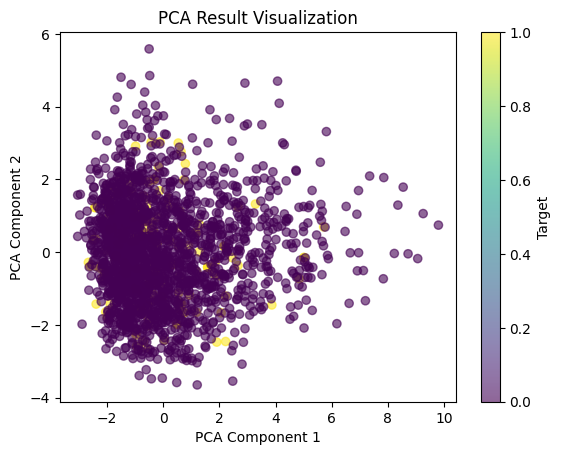

In [ ]:
# Visualize PCA effect in 2D space (if applicable)
if X_pca.shape[1] >= 2:
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("PCA Result Visualization")
    plt.colorbar(label="Target")
    plt.show()

In [ ]:
# Evaluate the effect of Dimensionality Reduction (PCA)
print("\nModel Evaluation:")
evaluate_model(X_pca, y, "variance thresholding")


Model Evaluation:
Model accuracy after variance thresholding: 0.9307


## Final datasets after processing
* Without Scaling: *processed_full_cohort_isp_v0.csv*
* Standard Scaling: *processed_full_cohort_isp_v1.csv* (Default)
* Robust Scaling: *processed_full_cohort_isp_v2.csv*

In [ ]:
# Save the final processed dataset after PCA for neural network input
final_df = pd.DataFrame(X_pca)
final_df['has_readmission'] = y.reset_index(drop=True)
final_df.to_csv('processed_full_cohort_isp_v1..csv', index=False)
files.download('processed_full_cohort_isp_v1..csv')
print("Data preprocessing complete. The processed dataset is saved as 'processed_full_cohort_isp_v1.csv'.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data preprocessing complete. The processed dataset is saved as 'processed_final_dataset.csv'.
